In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [14]:
EEG = scipy.io.loadmat("sampleEEGdata.mat")["EEG"][0, 0]
eegData = EEG["data"]
eegChanLabels = np.array([chan[0] for chan in EEG["chanlocs"][0]["labels"]])
eegChanLocsLabels=EEG["chanlocs"][0]["labels"]

## Figure 20.1

In [101]:
channel2plot = 'O1'

# wavelet parameters % Hz
min_freq = 2
max_freq = 30
num_freq = 20

# baseline time window
baseline_time = [-400, -100]

# other wavelet parameters
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_freq)
time = np.arange(-1, 1 + 1.0/EEG["srate"], 1/EEG["srate"])
half_of_wavelet_size = len(time) // 2

# FFT parameters
n_wavelet = len(time)
n_data =  int(EEG["pnts"] * EEG["trials"])
# ERP is only one trial-length
n_convolution = [n_wavelet + n_data - 1] * 2 + [int(n_wavelet + EEG["pnts"] - 1)]

# find sensor index
sensoridx = np.argmax([x[0] == channel2plot for x in eegChanLocsLabels])

# compute ERP
erp = np.squeeze(np.mean(eegData[sensoridx,:,:], 1))

# compute induced power by substracting ERP from each trial
induced_EEG = np.squeeze(eegData[sensoridx, :, :] - erp.reshape((-1, 1)))

# FFT of data
fft_EEG = [
    fft(np.reshape(eegData[sensoridx, :, :], (1, int(EEG["pnts"] * EEG["trials"])), order='F'), n_convolution[0]), # total
    fft(np.reshape(induced_EEG, (1, int(EEG["pnts"] * EEG["trials"])), order='F'), n_convolution[1]), # induced
    fft(erp, n_convolution[2]) # evoked; note that it doesn't matter that the FFT is longer than the time series
]

# convert baseline from ms to indices
baseidx = [
    np.argmin(np.abs(EEG["times"] - baseline_time[0])),
    np.argmin(np.abs(EEG["times"] - baseline_time[1]))  
]

# initialize output time-frequency data
tf = np.zeros((4, len(frequencies), int(EEG["pnts"])))

for fi in range(len(frequencies)):
    # create wavelet
    wavelet = np.exp(2 * 1j * np.pi * frequencies[fi] * time) * np.exp(-time**2 / (2*(4/(2 * np.pi * frequencies[fi])) ** 2)) / frequencies[fi]
    
    # run convolution for each of total, induced, and evoked
    for i in range(3):
        # take FFT of data
        fft_wavelet = fft(wavelet, n_convolution[i])
        
        # convolution...
        convolution_result_fft = ifft(fft_wavelet * fft_EEG[i], n_convolution[i]).reshape((-1, 1))
        convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-1 - half_of_wavelet_size + 1, :]
        
        # reshaping and trial averaging is done only on all trials
        if (i < 2):
            convolution_result_fft = np.reshape(convolution_result_fft, (int(EEG["pnts"]), int(EEG["trials"])), order='F')
            # compute power
            tf[i, fi, :] = np.mean(np.abs(convolution_result_fft)**2, 1)
        else:
            # with only one trial-length, just compute power with no averaging
            tf[i, fi, :] = np.squeeze(np.abs(convolution_result_fft)**2)
        # db correct power
        tf[i, fi, :] = 10 * np.log10( np.squeeze(tf[i,fi,:]) / np.mean(tf[i, fi, baseidx[0]:baseidx[1]]))
        
        # inter-trial phase consistency on total EEG
        if ( i == 0 ):
            tf[3, fi, :] = np.abs(np.mean(np.exp(1j * np.angle(convolution_result_fft)), 1))
            
analysis_labels = ['Total', 'Non-phase-locked', 'ERP power', 'ITPC']

# color limits
clims = np.array([[-3, 3], [-3, 3], [-12, 12], [0, 0.6]])

# scale ERP for plotting
erpt = (erp - np.min(erp)) / (np.max(erp) - np.min(erp))
erpt = erpt * (frequencies[-1] - frequencies[0]) + frequencies[0]

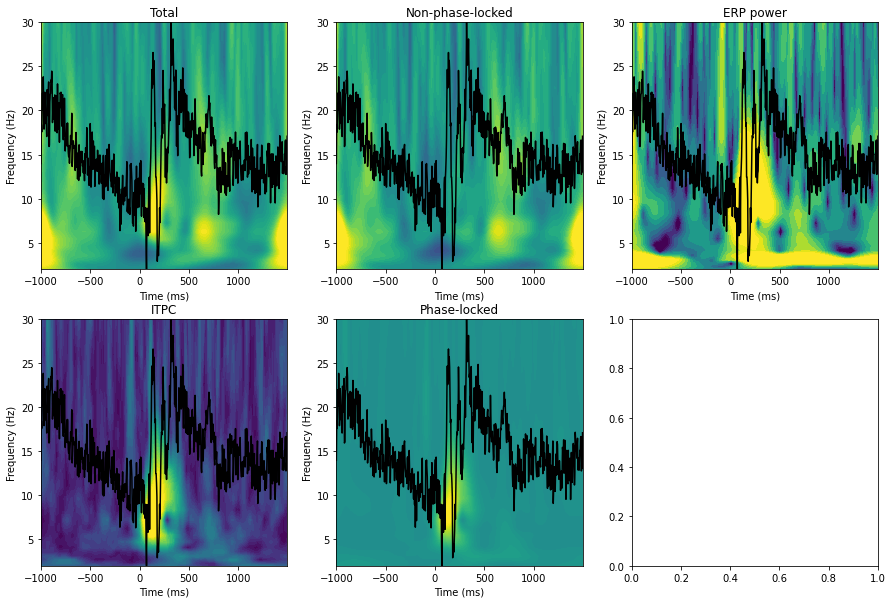

In [102]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
for i in range(4):
    idx = np.unravel_index(i, (2,3))
    ax[idx].contourf(np.squeeze(EEG["times"]), frequencies, tf[i,:,:], 40, vmin = clims[i][0], vmax = clims[i][1])
    ax[idx].set_xlabel('Time (ms)')
    ax[idx].set_ylabel('Frequency (Hz)')
    ax[idx].set_title(analysis_labels[i])
    ax[idx].plot(np.squeeze(EEG["times"]), erpt, 'k')
    
idx = np.unravel_index(4, (2,3))
ax[idx].contourf(np.squeeze(EEG["times"]), frequencies, tf[0,:,:] - tf[1,:,:], 40, vmin = clims[1][0], vmax = clims[1][1])
ax[idx].set_xlabel('Time (ms)')
ax[idx].set_ylabel('Frequency (Hz)')
ax[idx].set_title('Phase-locked')
ax[idx].plot(np.squeeze(EEG["times"]), erpt, 'k');

## Figure 20.2

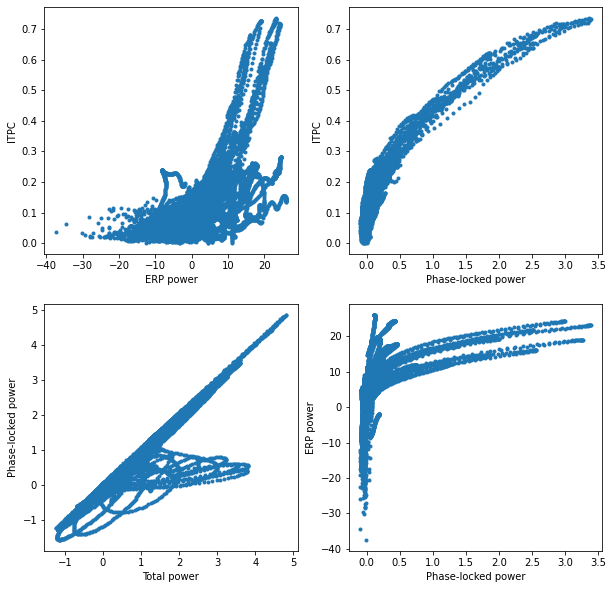

In [103]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].plot(tf[2].flatten('f'), tf[3].flatten('f'), '.')
ax[0][0].set(xlabel='ERP power', ylabel='ITPC')

ax[0][1].plot((tf[0]-tf[1]).flatten('f'), tf[3].flatten('f'), '.')
ax[0][1].set(xlabel='Phase-locked power', ylabel='ITPC')


ax[1][0].plot(tf[0].flatten('f'), tf[1].flatten('f'), '.')
ax[1][0].set(xlabel='Total power', ylabel='Phase-locked power')

ax[1][1].plot((tf[0]-tf[1]).flatten('f'), tf[2].flatten('f'), '.')
ax[1][1].set(xlabel='Phase-locked power', ylabel='ERP power');